In [335]:
import math
from fractions import Fraction
from typing import List, Dict, Tuple, Optional
import collections 
from collections import Counter
import matplotlib as plt
import re
import qiskit
import pyzx as zx
import networkx as nx
from pyzx.circuit import qasmparser
from pyzx.circuit import Circuit
from pyzx.tikz import to_tikz
from pyzx.circuit.gates import Gate, qasm_gate_table, ZPhase, XPhase, CRZ, gate_types


In [336]:
class cQASMParser(object):
    "This class takes a converted cqasm text file and converts it into the circuit"
    def __init__(self) -> None:
        "class initialization"
        self.gates : List[Gate] = []
        self.qubit_count : int = 0
        self.binary_count : int = 0
        self.circuit: Optional[Circuit] = None
    
    def parse(self, s: str, strict: bool = True) -> Circuit:
        "This allows us to split the text file by its commands and allows us to parse the commands in sequence"
        s = s.lower()
        lines = s.splitlines()
        r = []
        for s in lines:
            if s.find('#')!=-1:
                t = s[0:s.find('#')].strip() #here we are stripping all the lines that are not commented out by hashtags
            else:
                t = s.strip()
            if t : r.append(t)
        if r[0].startswith('version'): # here we pop the top line that denotes cqasm denotation
            r.pop(0)
        elif strict:
            raise TypeError("File doesnt start with cqasm denotation, please check you are using the correct text file type")
        data = "\n".join(r)
        commands = [s.strip() for s in data.split(";") if s.strip()] #here we are splitting the commands on the end of line semicolons
        for c in commands:
            if c.startswith(".") == False: #currently ignoring all initialization of named circuit areas, however investigation here is needed to deal with loops in code
                if c.count("{") == 0: #if there are no curly brackets we can parse the command as is
                    self.gates.extend(self.parse_command(c))
                elif c.count("{") > 0:
                    c = c.split("|")
                    for i in range(len(c)):
                        c[i] = c[i].strip()
                        if c[i].count("{") == 1:
                            c[i] = (c[i])[1:].strip()
                            self.gates.extend(self.parse_command(c[i]))
                        elif c[i].count("}") == 1:
                            c[i] = (c[i])[:-1].strip()
                            self.gates.extend(self.parse_command(c[i]))  
                        else:
                            self.gates.extend(self.parse_command(c[i]))        ## the above parses the simultaneously ran gates in a {gate | gate | gate} situation     
        circ = Circuit(self.qubit_count)
        circ.gates = self.gates # builds a circuit out of the necessary number of quibts and the gates that are parsed above
        self.circuit = circ
        return self.circuit # return said circuit
    
    
    def parse_command(self, c:str) -> List[Gate]:
        "Take the split arguements, pass them up and move on"
        gates : List[Gate] = []
        if c.startswith("measure"): return gates #preperation and measurement have little use in regards to our interests in converting the circuit to ZX calculus
        if c.startswith("prep"): return gates
        # the below code allows us to check what qubits are effected by the command, starting by seeing howmany gates and arguments the command entails
        name, rest = c.split(" ",1)
        qlist = []
        qlisttrue =[]
        if name.startswith('qubits'):
            if type(int(rest)) == int:
                self.qubit_count = int(rest)
                self.binary_count = int(rest)
            else:
                raise TypeError("Non integer number of qubits")
        ### 1 qubit gates
        if name in ("x","z","s","t","sdag","tdag","h"):
            if rest.count("q[") != 0: 
                if rest.count("q[") == 1:
                    rest = rest.split("[")[1]
                    rest = rest.split("]")[0]
                    rest = rest.split(",") 
        # above commands strip the numbers inside the square bracketsand split them into a list at the commas
                    for l in range(len(rest)):
                        if rest[l].count(":") == 0:
                            qlist.append(rest[l])
                        else: 
                            firstside = (rest[l].split(":")[0])[-1]
                            secondside = (rest[l].split(":")[1])[0]
                            for k in range(int(firstside),int(secondside)+1):
                                qlist.append(k)
                qlist = [int(i) for i in qlist]
                for i in qlist:
                    if i not in qlisttrue:
                        qlisttrue.append(i)  
                qlisttrue.sort() 
            for i in qlisttrue:
                if name in ('sdag'):
                    g = qasm_gate_table["sdg"](i)
                elif name in ("tdag"):
                 g = qasm_gate_table["tdg"](i)
                else:
                    g = qasm_gate_table[name](i)
                gates.append(g) 
                
        #the above commands find the qubits that the gates are acting on and append onto the circuit gate list what gates and qubits are enacted by this command
        
        ### 2 qubit gates 
        if name in ("cnot","cz","swap"):
            if rest.count("q[") != 2:
                raise TypeError("Incorrect number of gates") # checks the right amount of gates are referenced
            elif rest.count("q[") ==2:
                rest = rest.split("],")
                restcontrolqubit = rest[0]
                resttargetqubit = rest[1]
                restcontrolqubit = restcontrolqubit.split("[")[1]
                restcontrolqubit = restcontrolqubit.split("]")[0]
                restcontrolqubit = restcontrolqubit.split(",")
                resttargetqubit = resttargetqubit.split("[")[1]
                resttargetqubit = resttargetqubit.split("]")[0]
                resttargetqubit = resttargetqubit.split(",")   
                qlistcont = []
                qlisttarg = [] # splits the referenced qubits into both the group of control qubits and the group of target qubits
                for l in range(len(restcontrolqubit)):
                    if restcontrolqubit[l].count(":") == 0:
                        qlistcont.append(restcontrolqubit[l])
                    else: 
                        firstside = (restcontrolqubit[l].split(":")[0])[-1]
                        secondside = (restcontrolqubit[l].split(":")[1])[0]
                        for k in range(int(firstside),int(secondside)+1):
                            qlistcont.append(k)
                qlistcont = [int(i) for i in qlistcont]
                qlistconttrue = []
                for i in qlistcont:
                    if i not in qlistconttrue:
                        qlistconttrue.append(i)  
                qlistconttrue.sort()
     
                for l in range(len(resttargetqubit)):
                    if resttargetqubit[l].count(":") == 0:
                        qlisttarg.append(resttargetqubit[l])
                    else: 
                        firstside = (resttargetqubit[l].split(":")[0])[-1]
                        secondside = (resttargetqubit[l].split(":")[1])[0]
                        for k in range(int(firstside),int(secondside)+1):
                            qlisttarg.append(k)
                qlisttarg = [int(i) for i in qlisttarg]
                qlisttargtrue = []
                for i in qlisttarg:
                    if i not in qlisttargtrue:
                        qlisttargtrue.append(i)  
                qlisttargtrue.sort() 
            if len(qlistconttrue) == len(qlisttargtrue): 
                for i in range(len(qlistconttrue)):
                    if name in ('cnot'):
                        g = qasm_gate_table["cx"](qlistconttrue[i],qlisttargtrue[i])
                    elif name in ("cz"):
                        g = qasm_gate_table["cz"](qlistconttrue[i],qlisttargtrue[i])
                    elif name in ("swap"):
                        g = qasm_gate_table["swap"](qlistconttrue[i],qlisttargtrue[i])
                    gates.append(g)  # here we append the circuit gate list with the set gate referenced in the command with the proper qubits as control and target qubits
    
        ### 1 qubit gates with arguments
        if name in ("rx","ry","rz"):
            if rest.count("q[") != 0: ###
                if rest.count("q[") == 1:
                    rest = rest.split("],")
                    rest[0] = rest[0].split("[")[1]
                    rest[0] = rest[0].split("]")[0]
                    rest[0] = rest[0].split(",") 
                    qubitstring = rest[0] # here, the non-gate segment of the command comes in two parts, the qubits referenced and the arguement thereafter, so we split rest into rest[0] -> qubits and rest[1] -> arglist
                    argstring = rest[1]
                    args = int(argstring)
                    for l in range(len(qubitstring)):
                        if rest[l].count(":") == 0:
                            qlist.append(qubitstring[l])
                        else: 
                            firstside = (qubitstring[l].split(":")[0])[-1]
                            secondside = (qubitstring[l].split(":")[1])[0]
                            for k in range(int(firstside),int(secondside)+1):
                                qlist.append(k)
                qlist = [int(i) for i in qlist]
                for i in qlist:
                    if i not in qlisttrue:
                        qlisttrue.append(i)  
                qlisttrue.sort() 
            
            for i in qlisttrue:
                phase = self.parse_phase_arg(args)
                if name in ('rx'):
                    g = gate_types['XPhase'](i,phase = phase)
                #elif name in ("ry"):
                    #    g = qasm_gate_table['ry'](i,args) # i am still trying to figure out how we want to implement the y rotation gate, this will also come up later when it is necessary for me to look into the Y90 rotation gates.
                elif name in ("rz"):
                    g = gate_types['ZPhase'](i,phase = phase)
            gates.append(g)  
            
        ### Set 90 degree rotation gates for y and x phases
        if name in ("x90","y90","mx90","my90"):
            if rest.count("q[") != 0:
                if rest.count("q[") == 1:
                    rest = rest.split("],")
                    rest[0] = rest[0].split("[")[1]
                    rest[0] = rest[0].split("]")[0]
                    rest[0] = rest[0].split(",") 
                    qubitstring = rest[0]
            
                    for l in range(len(qubitstring)):
                        if rest[l].count(":") == 0:
                            qlist.append(qubitstring[l])
                        else: 
                            firstside = (qubitstring[l].split(":")[0])[-1]
                            secondside = (qubitstring[l].split(":")[1])[0]
                            for k in range(int(firstside),int(secondside)+1):
                                qlist.append(k)
                qlist = [int(i) for i in qlist]
                for i in qlist:
                    if i not in qlisttrue:
                        qlisttrue.append(i)  
                qlisttrue.sort() 
        
            for i in qlisttrue:
                if name =="x90":
                        phase = self.parse_phase_arg(math.pi/2)
                        g = gate_types["Xphase"](i, phase = phase)
                #elif name = "y90":
                    #phase = self.parse_phase_arg(math.pi/2)
                    #g = gate_types["Yphase"](i, phase = phase)
                elif name == "mx90":
                    phase = self.parse_phase_arg(-math.pi/2)
                    g = gate_types["Xphase"](i, phase = phase)
                #elif name = "my90":
                    #phase = self.parse_phase_arg(-math.pi/2)
                    #g = gate_types["Yphase"](i, phase = phase) # my concern here is the creaton of a Yphase gate that will be necessary
            gates.append(g)
            
            
        ### 2 qubit gates that take 1 argument
        if name in ("crk","cr"):
            rest = rest.split("],")
            restcontrolqubit = rest[0]
            resttargetqubit = rest[1]
            args = int(rest[2])
            restcontrolqubit = restcontrolqubit.split("[")[1]
            restcontrolqubit = restcontrolqubit.split("]")[0]
            restcontrolqubit = restcontrolqubit.split(",")
            resttargetqubit = resttargetqubit.split("[")[1]
            resttargetqubit = resttargetqubit.split("]")[0]
            resttargetqubit = resttargetqubit.split(",")   
            qlistcont = []
            qlisttarg = []
            for l in range(len(restcontrolqubit)):
                if restcontrolqubit[l].count(":") == 0:
                    qlistcont.append(restcontrolqubit[l])
                else: 
                    firstside = (restcontrolqubit[l].split(":")[0])[-1]
                    secondside = (restcontrolqubit[l].split(":")[1])[0]
                    for k in range(int(firstside),int(secondside)+1):
                        qlistcont.append(k)
            qlistcont = [int(i) for i in qlistcont]
            qlistconttrue = []
            for i in qlistcont:
                if i not in qlistconttrue:
                    qlistconttrue.append(i)  
            qlistconttrue.sort()
     
            for l in range(len(resttargetqubit)):
                if resttargetqubit[l].count(":") == 0:
                    qlisttarg.append(resttargetqubit[l])
            else: 
                firstside = (resttargetqubit[l].split(":")[0])[-1]
                secondside = (resttargetqubit[l].split(":")[1])[0]
                for k in range(int(firstside),int(secondside)+1):
                    qlisttarg.append(k)
            qlisttarg = [int(i) for i in qlisttarg]
            qlisttargtrue = []
            for i in qlisttarg:
                if i not in qlisttargtrue:
                    qlisttargtrue.append(i)  
            qlisttargtrue.sort() 
    
            if len(qlistconttrue) == len(qlisttargtrue): 
                for i in len(qlistconttrue):
                    phase = self.parse_phase_arg(args)
                    
                    if name in ('cr'):
                        g = qasm_gate_table["crz"](qlistconttrue[i],qlisttargtrue[i],phase)
                    elif name in ("crk"):
                        g = qasm_gate_table["crz"](qlistconttrue[i],qlisttargtrue[i],(math.pi/(2^args)))
                gates.append(g)  # this is a relatively straight forward implementation of gates that take two qubits, simply taking into account that we also need to parse the arg value
            
            
        ### toffoli gate implementation
        if name in ("toffoli"):
            rest = rest.split("],")
            for i in range(len(rest)):   
                rest[i] = rest[i].split("[")[1]
                rest[i] = rest[i].split("]")[0]
                rest[i] = rest[i].split(",") 
            for l in range(len(rest)):
                qlist=[]
                qlisttrue=[]
                if rest[l].count(":") == 0:
                    qlist.append((int(rest[l][0])))
                else: 
                    firstside = (rest[l].split(":")[0])[-1]
                    secondside = (rest[l].split(":")[1])[0]
                    for k in range(int(firstside),int(secondside)+1):
                        qlist.append(int(k))
                qlist = [int(i) for i in qlist]
                for i in qlist:
                    if i not in qlisttrue:
                        qlisttrue.append(i)  
            rest[l] = qlisttrue
            for i in range(len(rest)):
                if type(rest[i]) == list:
                    rest[i] = int(rest[i][0])
            g = gate_types['TOF'](rest[0],rest[1],rest[2])
            gates.append(g)
        return gates # tofolli gate implementation is similarly straightforward, simply recording the three relevat qubits
    
    def parse_phase_arg(self, val):
        #parse_phase_arg is used when we are parsing the phase arguments in our arg vals in relation to pi rotation
        try:
            phase = float(val)/math.pi
        except ValueError:
            if val.find('pi') == -1: raise TypeError("Invalid specification {}".format(name))
            try:
                val = val.replace('pi', '')
                val = val.replace('*','')
                if val.find('/') != -1:
                    n, d = val.split('/',1)
                    n = n.strip()
                    if not n: n = 1
                    elif n == '-': n = -1
                    else: n = int(n)
                    d = int(d.strip())
                    phase = Fraction(n,d)
                else:
                    val = val.strip()
                    if not val: phase = 1
                    else: phase = float(val)
            except: raise TypeError("Invalid specification {}".format(val))
            phase = Fraction(phase).limit_denominator(100000000)
            return phase            
    # the below command is how we call the above script into use
def cqasm(s: str) -> Circuit:
    "Parses a string representing a program in cQasm and outputs a circuit"
    p = cQASMParser()
    return p.parse(s, strict=False)

Here we see cQASM parser and its required imports, we are going to use this to compare cQASM and OPENQASM circuit scripts, both to show that we are producing the same circuit and that now PyZX can parse both equally.



In [337]:
with open("C:\\Users\\Ronan Corless\\Documents\\GitHub\\ThesisRepo\\circuitsfortesting\\cQASM\\adder_4.txt", 'r') as file:
    cqasmadder_4 = file.read().replace('','')
cqasmadder_4

'version 1.0;\nqubits 4;\nx q[0,2];\ntoffoli q[0],q[1],q[3];\ncnot    q[0],q[1];\ntoffoli q[1],q[2],q[3];\ncnot    q[1],q[2];\ncnot    q[0],q[1];'

In [338]:
with open("C:\\Users\\Ronan Corless\\Documents\\GitHub\\ThesisRepo\\circuitsfortesting\\OPENQASM\\adder_4.txt", 'r') as file:
    openqasmadder4 = file.read().replace('','')
openqasmadder4

'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg qubits[4];\nx qubits[0];\nx qubits[2];\nccx qubits[0],qubits[1],qubits[3];\ncx qubits[0], qubits[1];\nccx qubits[1], qubits[2], qubits[3];\ncx qubits[1], qubits[2];\ncx qubits[0], qubits[1];'

In [339]:
with open("C:\\Users\\Ronan Corless\\Documents\\GitHub\\ThesisRepo\\circuitsfortesting\\cQASM\\mod_4.txt", 'r') as file:
    cqasmmod_4 = file.read().replace('','')
cqasmmod_4

'version 1.0;\nqubits 5;\nx q[4];\nh q[4];\nh q[4];\ntoffoli q[0], q[3], q[4];\nh q[4];\nh q[4];\ntoffoli q[2], q[3], q[4];\nh q[4];\nh q[4];\ncnot q[3], q[4];\nh q[4];\nh q[4];\ntoffoli q[1], q[2], q[4];\nh q[4];\nh q[4];\ncnot q[2], q[4];\nh q[4];\nh q[4];\ntoffoli q[0],q[1],q[4];\nh q[4];\nh q[4];\ncnot q[1], q[4];\ncnot q[0], q[4];'

In [340]:

with open("C:\\Users\\Ronan Corless\\Documents\\GitHub\\ThesisRepo\\circuitsfortesting\\OPENQASM\\mod_4.txt", 'r') as file:
    openqasmmod_4 = file.read().replace('','')
openqasmmod_4

'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg qubits[5];\nx qubits[4];\nh qubits[4];\nh qubits[4];\nccx qubits[0],qubits[3],qubits[4];\nh qubits[4];\nh qubits[4];\nccx qubits[2],qubits[3],qubits[4];\nh qubits[4];\nh qubits[4];\ncx qubits[3],qubits[4];\nh qubits[4];\nh qubits[4];\nccx qubits[1],qubits[2],qubits[4];\nh qubits[4];\nh qubits[4];\ncx qubits[2],qubits[4];\nh qubits[4];\nh qubits[4];\nccx qubits[0],qubits[1],qubits[4];\nh qubits[4];\nh qubits[4];\ncx qubits[1],qubits[4];\ncx qubits[0],qubits[4];'

In [341]:
with open("C:\\Users\\Ronan Corless\\Documents\\GitHub\\ThesisRepo\\circuitsfortesting\\cQASM\\Tof_4.txt", 'r') as file:
    cqasmTof_4 = file.read().replace('','')
cqasmTof_4

'version 1.0;\nqubits 7;\nh q[4:6];\nh q[4:6];\ntoffoli q[0],q[1],q[4];\nh q[4];\nh q[4];\ntoffoli q[2],q[4],q[5];\nh q[5];\nh q[5];\ntoffoli q[3],q[5],q[6];\nh q[5,6];\nh q[5,6];\ntoffoli q[2],q[4],q[5];\nh q[4,5];\nh q[4,5];\ntoffoli q[0],q[1],q[4];'

In [342]:
with open("C:\\Users\\Ronan Corless\\Documents\\GitHub\\ThesisRepo\\circuitsfortesting\\OPENQASM\\Tof_4.txt", 'r') as file:
    openqasmtof_4 = file.read().replace('','')
openqasmtof_4

'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg qubits[7];\nh qubits[4];\nh qubits[4];\nccx qubits[0],qubits[1],qubits[4];\nh qubits[4];\nh qubits[4];\nh qubits[5];\nh qubits[5];\nccx qubits[2],qubits[4],qubits[5];\nh qubits[5];\nh qubits[5];\nh qubits[6];\nh qubits[6];\nccx qubits[3],qubits[5],qubits[6];\nh qubits[6];\nh qubits[6];\nh qubits[5];\nh qubits[5];\nccx qubits[2],qubits[4],qubits[5];\nh qubits[5];\nh qubits[5];\nh qubits[4];\nh qubits[4];\nccx qubits[0],qubits[1],qubits[4];\nh qubits[4];\nh qubits[4];'

We have now imported the cQASM and OPENQASM scripts for the mod_4 adder, the 4 bit adder and the toffoli 4 gates.

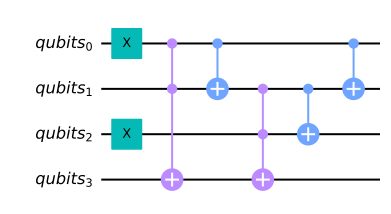

In [343]:
oqasmadd4_circ = qiskit.circuit.QuantumCircuit.from_qasm_str(openqasmadder4)
oqasmadd4_circ.draw(output= 'mpl')

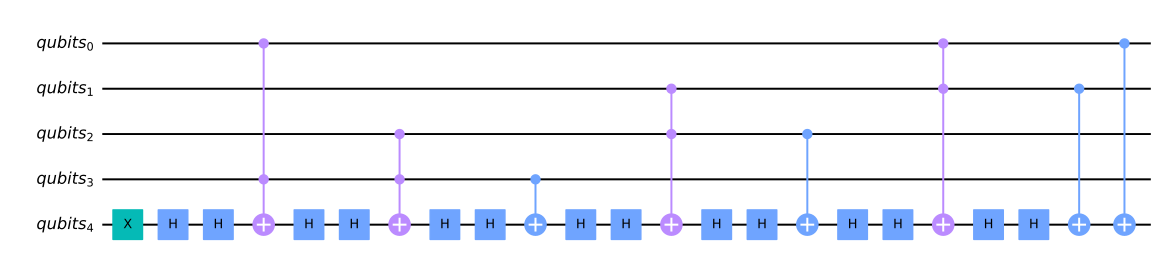

In [344]:
oqasmmod4_circ = qiskit.circuit.QuantumCircuit.from_qasm_str(openqasmmod_4)
oqasmmod4_circ.draw(output= 'mpl')


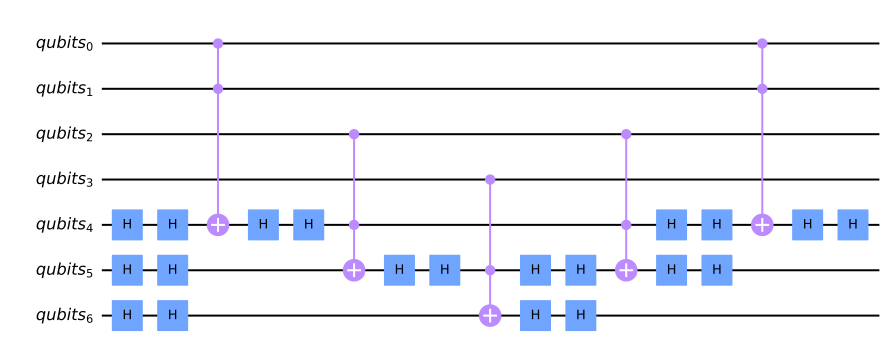

In [345]:
oqasmtof4_circ = qiskit.circuit.QuantumCircuit.from_qasm_str(openqasmtof_4)
oqasmtof4_circ.draw(output= 'mpl')

In [346]:
print(cqasm(cqasmadder_4).stats())

Circuit  on 4 qubits with 7 gates.
        14 is the T-count
        5 Cliffords among which 
        3 2-qubit gates (3 CNOT, 0 other) and
        0 Hadamard gates.
There are 2 gates of a different type


Circuit  on 4 qubits with 7 gates.
        14 is the T-count
        5 Cliffords among which 
        3 2-qubit gates (3 CNOT, 0 other) and
        0 Hadamard gates.
There are 2 gates of a different type


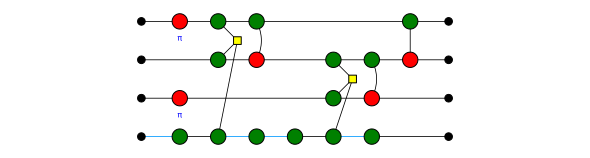

In [363]:
zxcqasmadd4 = cqasm(cqasmadder_4)
print(cqasm(cqasmadder_4).stats())
zx.draw_matplotlib(zxcqasmadd4)

Circuit  on 5 qubits with 23 gates.
        28 is the T-count
        19 Cliffords among which 
        4 2-qubit gates (4 CNOT, 0 other) and
        14 Hadamard gates.
There are 4 gates of a different type


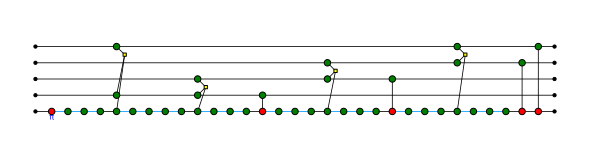

In [348]:
zxcQASMmod4 = cqasm(cqasmmod_4)
print(cqasm(cqasmmod_4).stats())
zx.draw_matplotlib(zxcQASMmod4)

Circuit  on 7 qubits with 23 gates.
        35 is the T-count
        18 Cliffords among which 
        0 2-qubit gates (0 CNOT, 0 other) and
        18 Hadamard gates.
There are 5 gates of a different type


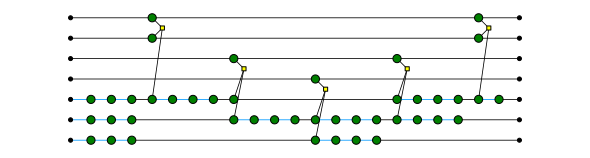

In [361]:
zxcqasmtof_4 = cqasm(cqasmTof_4)
print(cqasm(cqasmTof_4).stats())
zx.draw_matplotlib(zxcqasmtof_4)

Now lets look at PyZX simplifications of these circuits.

spider_simp: 6. 4. 2. 2. 2. 1.  6 iterations
id_simp: 5. 1.  2 iterations
spider_simp: 1.  1 iterations
pivot_simp: 1.  1 iterations
id_simp: 1.  1 iterations
pivot_gadget_simp: 3. 3. 2.  3 iterations
id_simp: 2.  1 iterations
spider_simp: 1.  1 iterations
gadget_simp: 1.  1 iterations
pivot_simp: 1.  1 iterations


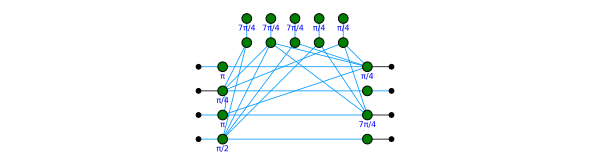

In [350]:
zxcqasmadd4simp = zxcqasmadd4.to_graph()
zx.full_reduce(zxcqasmadd4simp,quiet=False)
zxcqasmadd4simp.normalize()
zx.draw_matplotlib(zxcqasmadd4simp)


In [351]:
circuitzxadd4simp = zx.extract_circuit(zxcqasmadd4simp)
print(circuitzxadd4simp.stats())

Circuit  on 4 qubits with 48 gates.
        8 is the T-count
        40 Cliffords among which 
        17 2-qubit gates (0 CNOT, 17 other) and
        20 Hadamard gates.


spider_simp: 11. 9. 3. 3. 2. 1.  6 iterations
id_simp: 14. 7. 1.  3 iterations
spider_simp: 3.  1 iterations
pivot_simp: 4.  1 iterations
pivot_gadget_simp: 12. 4. 2. 1. 1.  5 iterations
id_simp: 8.  1 iterations
spider_simp: 1. 1. 1. 1.  4 iterations
gadget_simp: 4.  1 iterations
lcomp_simp: 4. 4.  2 iterations


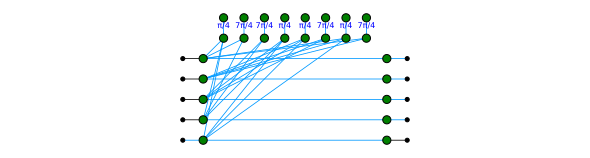

In [352]:
zxcQASMmod4simp = zxcQASMmod4.to_graph()
zx.full_reduce(zxcQASMmod4simp,quiet=False)
zxcQASMmod4simp.normalize()
zx.draw_matplotlib(zxcQASMmod4simp)

In [353]:
circuitzxmod4simp = zx.extract_circuit(zxcQASMmod4simp)
print(circuitzxmod4simp.stats())

Circuit  on 5 qubits with 65 gates.
        8 is the T-count
        57 Cliffords among which 
        23 2-qubit gates (0 CNOT, 23 other) and
        34 Hadamard gates.


spider_simp: 11. 10. 7. 3. 2. 1.  6 iterations
id_simp: 17. 9.  2 iterations
pivot_simp: 2.  1 iterations
pivot_gadget_simp: 13. 6. 2. 1.  4 iterations
id_simp: 3.  1 iterations
spider_simp: 1.  1 iterations
gadget_simp: 3.  1 iterations
lcomp_simp: 3. 3.  2 iterations


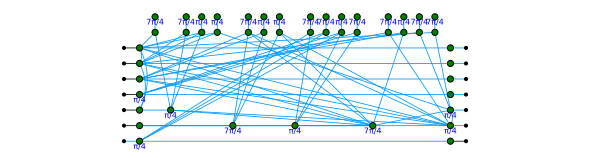

In [354]:
zxcqasmtof_4simp = zxcqasmtof_4.to_graph()
zx.full_reduce(zxcqasmtof_4simp,quiet=False)#
zxcqasmtof_4simp.normalize()
zx.draw_matplotlib(zxcqasmtof_4simp)

In [355]:
circuitzxtof4simp = zx.extract_circuit(zxcqasmtof_4simp)
print(circuitzxtof4simp.stats())

Circuit  on 7 qubits with 124 gates.
        23 is the T-count
        101 Cliffords among which 
        44 2-qubit gates (10 CNOT, 34 other) and
        56 Hadamard gates.
